In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Import Datasets
df_seq = pd.read_csv('./data/pdb_data_seq.csv')
df_char = pd.read_csv('./data/pdb_data_no_dups.csv')

In [3]:
# Filter for only proteins
protein_char = df_char[df_char.macromoleculeType == 'Protein']
protein_seq = df_seq[df_seq.macromoleculeType == 'Protein']

# Select only necessary variables to join
protein_char = protein_char[['structureId','classification']]
protein_seq = protein_seq[['structureId','sequence']]

In [4]:
model_f=protein_seq.merge(protein_char,on=['structureId']).reset_index(drop=True)

In [5]:
model_f.shape

(346325, 3)

In [6]:
model_f = model_f.dropna()

In [7]:
model_f.shape

(346321, 3)

In [8]:
counts = model_f.classification.value_counts()
# Get classification types where counts are over 1000
types = np.asarray(counts[(counts > 1000)].index)

# Filter dataset's records for classification types > 1000
data = model_f[model_f.classification.isin(types)]

In [9]:
num_classes=len(data['classification'].unique())

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# Split Data
train_X_o, test_X_o, train_Y_o1, test_Y_o1 = \
train_test_split(data['sequence'], data['classification'], test_size = 0.2)

le.fit(data['classification'])
train_Y_o=le.transform(train_Y_o1)
test_Y_o=le.transform(test_Y_o1)

# Create a Count Vectorizer to gather the unique elements in sequence
vect = CountVectorizer(analyzer = 'char_wb', ngram_range = (4,5))

# Fit and Transform CountVectorizer
vect.fit(train_X_o)
train_X_comp= vect.transform(train_X_o)
test_X_comp= vect.transform(test_X_o)



In [15]:
from retrieveEnsemble import ensemble
from retrieveEnsemble import opt_weight,retrieve_add,retrieve_replace
from sklearn.naive_bayes import MultinomialNB

ModuleNotFoundError: No module named 'retrieveEnsemble'

In [ ]:
NB = MultinomialNB()

layer1=[NB]

trainX_l1,testX_l1,modelInfo_l1=ensemble(layer_name='layer1',models=layer1,
                                         train_x=train_X_comp,train_y=train_Y_o,test_x=test_X_comp,
                                         n_classes=43,n_folds=5,
                                         metric_for_classifier='log_loss',
                                         metric_for_regressor='mean_squared_error')

In [11]:
from sklearn.preprocessing import LabelBinarizer

# Transform labels to one-hot
lb = LabelBinarizer()

train_Y=lb.fit_transform(train_Y_o1)
test_Y = lb.transform(test_Y_o1)

In [12]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer

# maximum length of sequence, everything afterwards is discarded!
max_length = 1024

#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(data['sequence'])
#represent input data as word rank number sequences
train_X = tokenizer.texts_to_sequences(train_X_o)
test_X=tokenizer.texts_to_sequences(test_X_o)
train_X = pd.DataFrame(sequence.pad_sequences(train_X, maxlen=max_length))
test_X = pd.DataFrame(sequence.pad_sequences(test_X, maxlen=max_length))
'''
from sklearn.preprocessing import MinMaxScaler
for e in list(train_X):
    scaler=MinMaxScaler()
    scaler.fit(train_X[e].values.reshape(-1, 1))
    train_X[e]=scaler.transform(train_X[e].values.reshape(-1, 1))
    test_X[e]=scaler.transform(test_X[e].values.reshape(-1, 1))
'''

/home/zhengma/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'\nfrom sklearn.preprocessing import MinMaxScaler\nfor e in list(train_X):\n    scaler=MinMaxScaler()\n    scaler.fit(train_X[e].values.reshape(-1, 1))\n    train_X[e]=scaler.transform(train_X[e].values.reshape(-1, 1))\n    test_X[e]=scaler.transform(test_X[e].values.reshape(-1, 1))\n'

In [13]:
test_X.shape

(55774, 1024)

In [14]:
test_X_o.head()

232156    NKEYTEEQKQTLEQEQKEFLSQTTTPELEADDGFIVTSESSAQSTP...
175895    GSHMDAFDTLFDHAPDKLNVVKKTLITFVNKHLNKLNLEVTELETQ...
309789    MFLTRSEYDRGVSTFSPEGRLFQVEYSLEAIKLGSTAIGIATKEGV...
82525                  KPERIVFNFNLIYPENDEEFNTEEILAMIKGLYKVQ
141780    SNAHKGTLYVVATPLGNLDDMTFRAVNTLRNAGAIACEDTRRTSIL...
Name: sequence, dtype: object

In [15]:
test_X.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,0,0,...,2,5,7,9,9,9,3,15,3,15
1,0,0,0,0,0,0,0,0,0,0,...,13,1,14,8,10,16,11,13,4,5
2,0,0,0,0,0,0,0,0,0,0,...,6,12,5,5,2,7,4,5,18,6
3,0,0,0,0,0,0,0,0,0,0,...,2,18,9,10,3,1,16,10,4,15
4,0,0,0,0,0,0,0,0,0,0,...,3,1,12,4,4,12,4,12,3,2


In [21]:
train_Xddd=pd.concat([train_X,trainX_l1],axis=1,ignore_index=True).as_matrix()
test_Xddd=pd.concat([test_X,testX_l1],axis=1,ignore_index=True).as_matrix()
train_X=train_X.as_matrix()
test_X=test_X.as_matrix()

NameError: name 'trainX_l1' is not defined

In [12]:
'''
# Make a prediction dictionary to store accuracys
prediction = dict()

# Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(train_X_comp, train_Y_o1)
NB_pred = model.predict(test_X_comp)
prediction["MultinomialNB"] = accuracy_score(NB_pred, test_Y_o1)
print( prediction['MultinomialNB'])
'''

'\n# Make a prediction dictionary to store accuracys\nprediction = dict()\n\n# Naive Bayes Model\nfrom sklearn.naive_bayes import MultinomialNB\nmodel = MultinomialNB()\nmodel.fit(train_X_comp, train_Y_o1)\nNB_pred = model.predict(test_X_comp)\nprediction["MultinomialNB"] = accuracy_score(NB_pred, test_Y_o1)\nprint( prediction[\'MultinomialNB\'])\n'

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

embedding_dim = 8

# create the model
model = Sequential()
#model.add(Embedding(26, embedding_dim, input_length=max_length+num_classes))
#model.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Flatten())
model.add(Dense(72,input_shape=(max_length+num_classes,), activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 72)                76896     
_________________________________________________________________
dense_32 (Dense)             (None, 24)                1752      
_________________________________________________________________
dense_33 (Dense)             (None, 43)                1075      
Total params: 79,723
Trainable params: 79,723
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
model.fit(train_Xddd, train_Y, validation_data=(test_Xddd, test_Y), epochs=100, batch_size=128)

Train on 223092 samples, validate on 55774 samples
Epoch 1/100
223092/223092 [==============================] - 10s - loss: 2.3556 - acc: 0.3912 - val_loss: 1.5717 - val_acc: 0.6259
Epoch 2/100
223092/223092 [==============================] - 9s - loss: 1.2721 - acc: 0.7196 - val_loss: 1.0970 - val_acc: 0.7644
Epoch 3/100
223092/223092 [==============================] - 9s - loss: 1.0244 - acc: 0.7881 - val_loss: 0.9476 - val_acc: 0.8028
Epoch 4/100
223092/223092 [==============================] - 9s - loss: 0.9380 - acc: 0.8070 - val_loss: 0.9167 - val_acc: 0.8072
Epoch 5/100
223092/223092 [==============================] - 9s - loss: 0.8883 - acc: 0.8156 - val_loss: 0.8186 - val_acc: 0.8289
Epoch 6/100
223092/223092 [==============================] - 9s - loss: 0.8545 - acc: 0.8204 - val_loss: 0.8038 - val_acc: 0.8324
Epoch 7/100
223092/223092 [==============================] - 9s - loss: 0.8255 - acc: 0.8246 - val_loss: 0.7756 - val_acc: 0.8359
Epoch 8/100
223092/223092 [===========

223092/223092 [==============================] - 9s - loss: 0.5926 - acc: 0.8554 - val_loss: 0.6928 - val_acc: 0.8479
Epoch 64/100
223092/223092 [==============================] - 9s - loss: 0.5895 - acc: 0.8554 - val_loss: 0.6897 - val_acc: 0.8488
Epoch 65/100
223092/223092 [==============================] - 9s - loss: 0.5893 - acc: 0.8554 - val_loss: 0.6883 - val_acc: 0.8467
Epoch 66/100
223092/223092 [==============================] - 9s - loss: 0.5888 - acc: 0.8554 - val_loss: 0.6923 - val_acc: 0.8464
Epoch 67/100
223092/223092 [==============================] - 9s - loss: 0.5873 - acc: 0.8561 - val_loss: 0.7069 - val_acc: 0.8435
Epoch 68/100
223092/223092 [==============================] - 9s - loss: 0.5868 - acc: 0.8554 - val_loss: 0.6841 - val_acc: 0.8473
Epoch 69/100
223092/223092 [==============================] - 9s - loss: 0.5862 - acc: 0.8562 - val_loss: 0.6980 - val_acc: 0.8452
Epoch 70/100
223092/223092 [==============================] - 9s - loss: 0.5837 - acc: 0.8566 - 

RESULT for NB-ANN:
test-acc = 0.8500376519525227


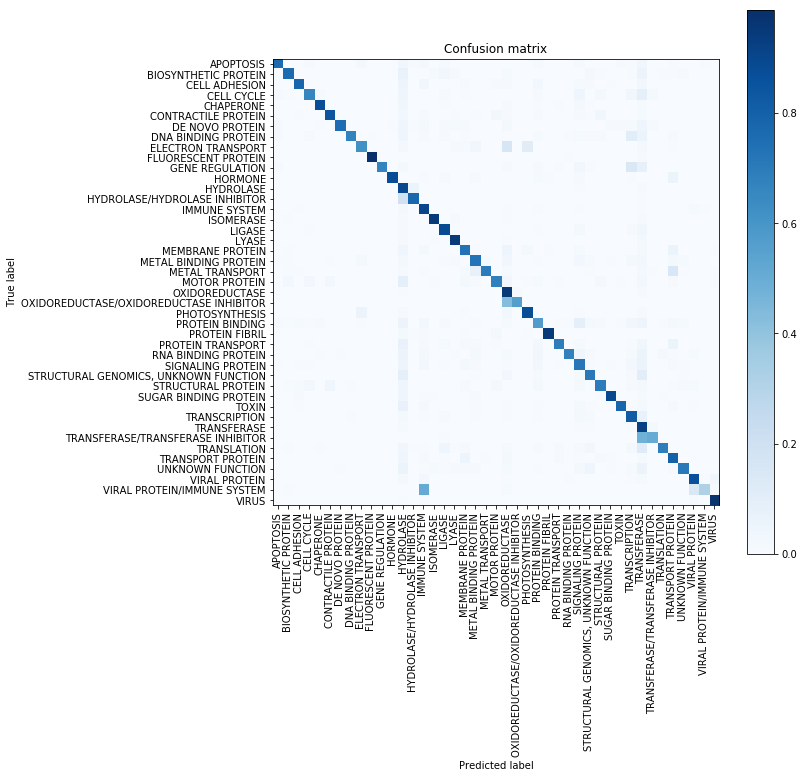

                                         precision    recall  f1-score   support

                              APOPTOSIS       0.74      0.76      0.75       263
                   BIOSYNTHETIC PROTEIN       0.71      0.76      0.73       220
                          CELL ADHESION       0.86      0.78      0.82       609
                             CELL CYCLE       0.81      0.66      0.73       538
                              CHAPERONE       0.93      0.87      0.90       800
                    CONTRACTILE PROTEIN       0.79      0.85      0.82       215
                        DE NOVO PROTEIN       0.89      0.75      0.82       322
                    DNA BINDING PROTEIN       0.90      0.67      0.77       647
                     ELECTRON TRANSPORT       0.79      0.62      0.69       569
                    FLUORESCENT PROTEIN       0.95      0.99      0.97       218
                        GENE REGULATION       0.93      0.66      0.78       309
                           

In [41]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

print("RESULT for NB-ANN:")
test_pred = model.predict(test_Xddd)
print("test-acc = " + str(accuracy_score(np.argmax(test_Y, axis=1), np.argmax(test_pred, axis=1))))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(test_Y, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
#for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(np.argmax(test_Y, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

In [42]:

embedding_dim = 8

# create the model
model2 = Sequential()
#model.add(Embedding(26, embedding_dim, input_length=max_length))
#model.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Flatten())

model2.add(Dense(72,input_shape=(max_length,), activation='relu'))
model2.add(Dense(24, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 72)                73800     
_________________________________________________________________
dense_35 (Dense)             (None, 24)                1752      
_________________________________________________________________
dense_36 (Dense)             (None, 43)                1075      
Total params: 76,627
Trainable params: 76,627
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
model2.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=100, batch_size=128)

Train on 223092 samples, validate on 55774 samples
Epoch 1/100
223092/223092 [==============================] - 8s - loss: 2.7161 - acc: 0.2806 - val_loss: 2.4555 - val_acc: 0.3549
Epoch 2/100
223092/223092 [==============================] - 7s - loss: 2.3366 - acc: 0.3863 - val_loss: 2.2701 - val_acc: 0.4091
Epoch 3/100
223092/223092 [==============================] - 7s - loss: 2.1716 - acc: 0.4332 - val_loss: 2.1836 - val_acc: 0.4337
Epoch 4/100
223092/223092 [==============================] - 7s - loss: 2.0760 - acc: 0.4608 - val_loss: 2.0962 - val_acc: 0.4589
Epoch 5/100
223092/223092 [==============================] - 7s - loss: 2.0093 - acc: 0.4797 - val_loss: 2.0468 - val_acc: 0.4763
Epoch 6/100
223092/223092 [==============================] - 7s - loss: 1.9562 - acc: 0.4942 - val_loss: 2.0306 - val_acc: 0.4829
Epoch 7/100
223092/223092 [==============================] - 7s - loss: 1.9157 - acc: 0.5058 - val_loss: 1.9993 - val_acc: 0.4920
Epoch 8/100
223092/223092 [============

RESULT for ANN:
test-acc = 0.5773478681823072


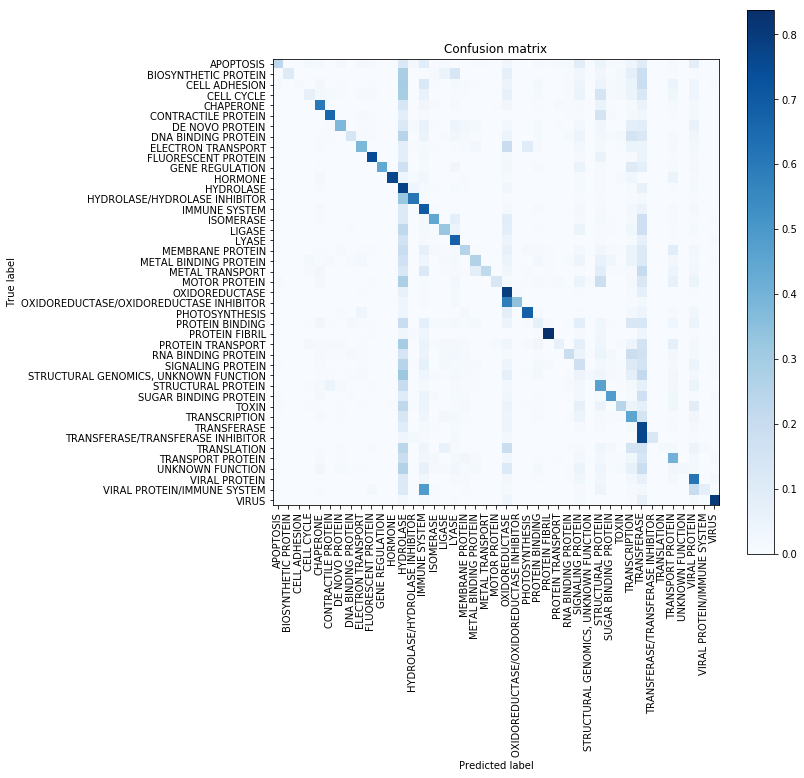

                                         precision    recall  f1-score   support

                              APOPTOSIS       0.66      0.23      0.34       263
                   BIOSYNTHETIC PROTEIN       0.61      0.10      0.18       220
                          CELL ADHESION       0.57      0.01      0.01       609
                             CELL CYCLE       0.43      0.07      0.12       538
                              CHAPERONE       0.62      0.60      0.61       800
                    CONTRACTILE PROTEIN       0.59      0.66      0.62       215
                        DE NOVO PROTEIN       0.59      0.38      0.46       322
                    DNA BINDING PROTEIN       0.59      0.13      0.22       647
                     ELECTRON TRANSPORT       0.59      0.38      0.46       569
                    FLUORESCENT PROTEIN       0.61      0.75      0.67       218
                        GENE REGULATION       1.00      0.44      0.61       309
                           

In [44]:
print("RESULT for ANN:")
test_pred = model2.predict(test_X)
print("test-acc = " + str(accuracy_score(np.argmax(test_Y, axis=1), np.argmax(test_pred, axis=1))))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(test_Y, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
#for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(np.argmax(test_Y, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

In [36]:
embedding_dim = 8

# create the model
model3 = Sequential()
model3.add(Embedding(26, embedding_dim, input_length=max_length))
model3.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Flatten())
model3.add(Dense(72, activation='relu'))
model3.add(Dense(24, activation='relu'))
model3.add(Dense(num_classes, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1024, 8)           208       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1024, 64)          3136      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 512, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 512, 32)           6176      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 256, 32)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 72)                589896    
__________

In [37]:
model3.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=100, batch_size=128)

Train on 223092 samples, validate on 55774 samples
Epoch 1/100
223092/223092 [==============================] - 306s - loss: 2.3628 - acc: 0.3688 - val_loss: 1.9138 - val_acc: 0.4958
Epoch 2/100
223092/223092 [==============================] - 320s - loss: 1.6178 - acc: 0.5758 - val_loss: 1.4977 - val_acc: 0.6089
Epoch 3/100
223092/223092 [==============================] - 318s - loss: 1.3017 - acc: 0.6589 - val_loss: 1.3182 - val_acc: 0.6616
Epoch 4/100
223092/223092 [==============================] - 318s - loss: 1.1293 - acc: 0.7025 - val_loss: 1.2046 - val_acc: 0.6970
Epoch 5/100
223092/223092 [==============================] - 320s - loss: 1.0167 - acc: 0.7309 - val_loss: 1.1476 - val_acc: 0.7117
Epoch 6/100
223092/223092 [==============================] - 316s - loss: 0.9337 - acc: 0.7516 - val_loss: 1.0906 - val_acc: 0.7317
Epoch 7/100
223092/223092 [==============================] - 320s - loss: 0.8651 - acc: 0.7686 - val_loss: 1.0847 - val_acc: 0.7363
Epoch 8/100
223092/223092

RESULT for CNN:
test-acc = 0.8402122852942231


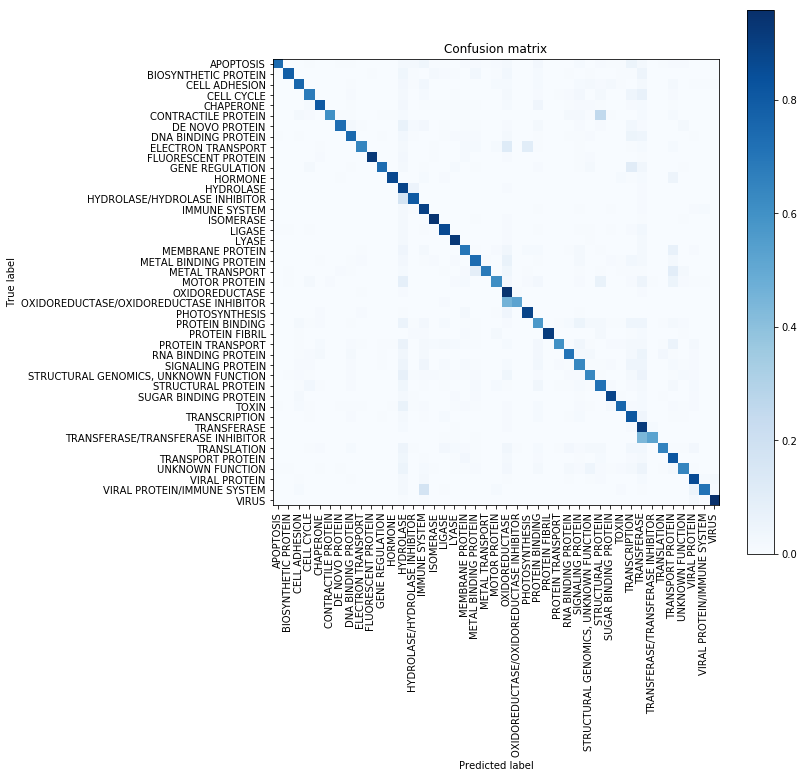

                                         precision    recall  f1-score   support

                              APOPTOSIS       0.77      0.74      0.75       263
                   BIOSYNTHETIC PROTEIN       0.81      0.79      0.80       220
                          CELL ADHESION       0.77      0.76      0.76       609
                             CELL CYCLE       0.75      0.68      0.71       538
                              CHAPERONE       0.88      0.81      0.84       800
                    CONTRACTILE PROTEIN       0.89      0.60      0.72       215
                        DE NOVO PROTEIN       0.81      0.73      0.77       322
                    DNA BINDING PROTEIN       0.78      0.75      0.76       647
                     ELECTRON TRANSPORT       0.84      0.64      0.73       569
                    FLUORESCENT PROTEIN       0.93      0.92      0.92       218
                        GENE REGULATION       0.82      0.73      0.77       309
                           

In [38]:
print("RESULT for CNN:")
test_pred = model3.predict(test_X)
print("test-acc = " + str(accuracy_score(np.argmax(test_Y, axis=1), np.argmax(test_pred, axis=1))))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(test_Y, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
#for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(np.argmax(test_Y, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

In [34]:
embedding_dim = 8

# create the model
model4 = Sequential()
model4.add(Embedding(26, embedding_dim, input_length=max_length+43))
model4.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Flatten())
model4.add(Dense(72, activation='relu'))
model4.add(Dense(24, activation='relu'))
model4.add(Dense(num_classes, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1067, 8)           208       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1067, 64)          3136      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 533, 64)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 533, 32)           6176      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 266, 32)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8512)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 72)                612936    
__________

In [35]:
model4.fit(train_Xddd, train_Y, validation_data=(test_Xddd, test_Y), epochs=100, batch_size=128)

Train on 223092 samples, validate on 55774 samples
Epoch 1/100
223092/223092 [==============================] - 287s - loss: 1.0900 - acc: 0.7571 - val_loss: 0.9439 - val_acc: 0.7749
Epoch 2/100
223092/223092 [==============================] - 312s - loss: 0.7687 - acc: 0.8229 - val_loss: 0.8946 - val_acc: 0.7832
Epoch 3/100
223092/223092 [==============================] - 316s - loss: 0.7114 - acc: 0.8295 - val_loss: 0.8654 - val_acc: 0.7881
Epoch 4/100
223092/223092 [==============================] - 322s - loss: 0.6633 - acc: 0.8367 - val_loss: 0.8360 - val_acc: 0.7935
Epoch 5/100
223092/223092 [==============================] - 326s - loss: 0.6222 - acc: 0.8420 - val_loss: 0.8259 - val_acc: 0.7985
Epoch 6/100
223092/223092 [==============================] - 323s - loss: 0.5869 - acc: 0.8475 - val_loss: 0.8071 - val_acc: 0.8035
Epoch 7/100
223092/223092 [==============================] - 329s - loss: 0.5552 - acc: 0.8528 - val_loss: 0.7961 - val_acc: 0.8075
Epoch 8/100
223092/223092

KeyboardInterrupt: 

In [ ]:
print("RESULT for CNN+NB:")
test_pred = model3.predict(test_X)
print("test-acc = " + str(accuracy_score(np.argmax(test_Y, axis=1), np.argmax(test_pred, axis=1))))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(test_Y, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
#for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(np.argmax(test_Y, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))